In [ ]:
from typing import NamedTuple, Optional, Tuple, Generator
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import circle_perimeter_aa

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 5.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=e662871f401bf2d8d734378897cdf3abdc6e907b6791dd9330604a6dc740ea60
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import wandb
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
class CircleParams(NamedTuple):
  row: int
  col: int
  radius: int

In [ ]:
def draw_circle(img: np.ndarray, row: int, col: int, radius: int) -> np.ndarray:
    """
    Draw a circle in a numpy array, inplace.
    The center of the circle is at (row, col) and the radius is given by radius.
    The array is assumed to be square.
    Any pixels outside the array are ignored.
    Circle is white (1) on black (0) background, and is anti-aliased.
    """
    rr, cc, val = circle_perimeter_aa(row, col, radius)
    valid = (rr >= 0) & (rr < img.shape[0]) & (cc >= 0) & (cc < img.shape[1])
    img[rr[valid], cc[valid]] = val[valid]
    return img


In [ ]:
def noisy_circle(
    img_size: int, min_radius: float, max_radius: float, noise_level: float
) -> Tuple[np.ndarray, CircleParams]:
    """
    Draw a circle in a numpy array, with normal noise.
    """

    # Create an empty image
    img = np.zeros((img_size, img_size))

    radius = np.random.randint(min_radius, max_radius)

    # x,y coordinates of the center of the circle
    row, col = np.random.randint(img_size, size=2)

    # Draw the circle inplace
    draw_circle(img, row, col, radius)

    added_noise = np.random.normal(0.5, noise_level, img.shape)
    img += added_noise

    return img, CircleParams(row, col, radius)

In [128]:
def show_circle(img: np.ndarray, row, col):
    img = np.squeeze(img,axis=0)
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    plt.scatter(col,row)
    ax.set_title('Circle')
    plt.show()

In [ ]:
import torchvision.transforms.functional as TF

In [ ]:
class MyMirrorTransform:
    """Rotate by one of the given angles."""
    def __init__(self, setting):
        self.setting = setting
        self.parameters = self.setting.Mirror
        self.apply_prob = np.random.rand(1)

    def apply_image(self, image):
        return TF.hflip(image)

    def apply_keypoints(self,image,col):
      mid_point = int(image.shape[1]/2)
      if col > mid_point:
          distance = col - mid_point
          col = mid_point - distance
      else:
          distance = mid_point - col
          col = mid_point + distance
      return col

    def __call__(self, image, col):
        if self.parameters['prob'] > self.apply_prob:
          return self.apply_image(image), self.apply_keypoints(image,col)
        return image,col

In [ ]:
def generate_examples(
    noise_level: float = 0.5,
    img_size: int = 100,
    min_radius: Optional[int] = None,
    max_radius: Optional[int] = None,
    dataset_path: str = 'ds',
) -> Generator[Tuple[np.ndarray, CircleParams], None, None]:
    if not min_radius:
        min_radius = img_size // 10
    if not max_radius:
        max_radius = img_size // 2
    assert max_radius > min_radius, "max_radius must be greater than min_radius"
    assert img_size > max_radius, "size should be greater than max_radius"
    assert noise_level >= 0, "noise should be non-negative"

    params = f"{noise_level=}, {img_size=}, {min_radius=}, {max_radius=}, {dataset_path=}"
    print(f"Using parameters: {params}")
    while True:
        img, params = noisy_circle(
            img_size=img_size, min_radius=min_radius, max_radius=max_radius, noise_level=noise_level
        )
        yield img, params

In [ ]:
def iou(a: CircleParams, b: CircleParams) -> float:
    """Calculate the intersection over union of two circles"""
    r1, r2 = a.radius, b.radius
    d = np.linalg.norm(np.array([a.row, a.col]) - np.array([b.row, b.col]))
    if d > r1 + r2:
        return 0
    if d <= abs(r1 - r2):
        return 1
    r1_sq, r2_sq = r1**2, r2**2
    d1 = (r1_sq - r2_sq + d**2) / (2 * d)
    d2 = d - d1
    h1 = r1_sq * np.arccos(d1 / r1)
    h2 = d1 * np.sqrt(r1_sq - d1**2)
    h3 = r2_sq * np.arccos(d2 / r2)
    h4 = d2 * np.sqrt(r2_sq - d2**2)
    intersection = h1 + h2 + h3 + h4
    union = np.pi * (r1_sq + r2_sq) - intersection
    return intersection / union

In [ ]:
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

In [ ]:
class Setting():
  def __init__(self):
    self.seed = 123
    self.pretrained = '/content/drive/MyDrive/coding_challenge/model1_20.pth'  # Pretrained model weights
    self.checkpoint = ''  
    self.verbose_freq = 20  # Frequency to print training metrics
    self.valid_freq = 50  # Frequency to perform validation step
    self.n_epochs = 25
    self.batch_size = 16
    

    ############################################################################################################
    self.PATHDATA = '/content/drive/MyDrive/coding_challenge'
    self.DATA_TRAIN = self.PATHDATA + '/train'
    self.DATA_VAL  = self.PATHDATA + '/validation'
    self.DATA_TEST = self.PATHDATA + '/test'
    self.LOW_TRAIN  = self.PATHDATA + '/low_train'
    self.LOW_VAL  = self.PATHDATA + '/low_validation'
    self.LOW_TEST = self.PATHDATA + '/low_test'
    ############################################################################################################

    self.opt_hyp = {
      'adam': True,
      'nbs': 16,
      'lr0': 0.01,  # 0.01,
      'momentum': 0.87,
      'weight_decay': 0.00005,  # 0.0005,
      }

    self.Mirror = {
          'prob': 1,
    }

    self.Rotate = {
      'prob': 1,
      'range': (-20, 20)
    }

    self.Shift = {
      'prob': 1,
      'range': {
      'x': (-5, 5),
      'y': (-3, 3)
      }
    }


In [ ]:
wandb.init(project = 'Coding_challenge',
           config = {'learning_rate': setting.opt_hyp['lr0'],
                     'batch_size': setting.batch_size,
                     'epochs': setting.n_epochs,
                     'weight_decay': setting.opt_hyp['weight_decay']})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
generator = generate_examples()


directory  = '/content/drive/MyDrive/coding_challenge/train'
for i in range(0,3000):

  img,params = next(generator)

  image = np.array(img, dtype =np.float32)
  row = np.array(params[0], dtype=np.int32)
  col = np.array(params[1] , dtype = np.int32)
  radius = np.array(params[2], dtype = np.int32)
  name = directory + "/" + "Circle_train" + str(i)
  np.savez(image = image, x = row, y = col, r = radius, file = name )

Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


In [ ]:
def np_to_circleparams(labels):
  labels = np.transpose(labels)
  x,y,r = labels
  output = []
  for curr_row,curr_col,curr_radius in zip(x,y,r):
    output.append(CircleParams(curr_row, curr_col, curr_radius))
  return output

In [125]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
from PIL import Image

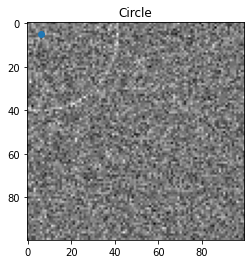

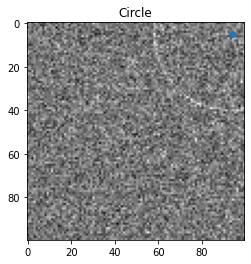

In [129]:
arrays = np.load('/content/drive/MyDrive/coding_challenge/train/Circle_val2.npz')
x = arrays['x']
y = arrays['y']
r = arrays['r']
image = arrays['image']
image = np.expand_dims(image,axis=0)
show_circle(image, x, y)
image = torch.tensor(image)

image,col = mirror(image,y)
show_circle(image, x,col)


In [ ]:
class InputPipeline(Dataset):
  def __init__(self, setting, data_dir, train=True):
    super().__init__()
    self.data_dir = data_dir

    self.files = os.listdir(self.data_dir)
    self.train = train

    self.mirror = MyMirrorTransform(setting)
  
  def __len__(self):
    return len(self.files)

  def load(self,file: str):
    '''
      Load npz files to extract image and parameters
    '''

    file = os.path.join(self.data_dir,file)
    arrays = np.load(file)
    image = arrays['image']

    x = arrays['x']
    y = arrays['y']
    r = arrays['r']
    return image,x,y,r

  def visualize(self, image: np.ndarray):
    '''
      Helper function to visualize 
    '''
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.set_title('Circle')
    plt.show()

  def preprocess_onlyGaussian(self, image: np.ndarray, kernel_size = (5,5)):
    '''
    Preprocess: Remove Gaussian Noise & Normalize
    '''
    median0 = cv2.GaussianBlur(image.astype('float32'), kernel_size, 1)

    image = (median0 - np.min(median0)) / (np.max(median0) - np.min(median0))

    image = np.expand_dims(image, axis=0)
    return image

  def preprocess(self, image: np.ndarray, kernel_size = (5,5), sigma = 0.08):   
    '''
    Preprocess: Remove Gaussian Noise, Non-Local means filter and Normalize
    '''  
    median0 = cv2.GaussianBlur(image.astype('float32'), kernel_size, 1)
    noisy = random_noise(median0.astype('float32'), var=sigma**2)   

    sigma_est = np.mean(estimate_sigma(noisy))    
    patch_kw = dict(patch_size=5,patch_distance=6)    
    image = denoise_nl_means(noisy, h=0.8 * sigma_est, sigma=sigma_est,
                            fast_mode=False, **patch_kw) 
    image = np.expand_dims(image, axis=0)
    return image
    
  def normalize(self, image: np.ndarray, kernel_size = (5,5)):
     image = (image - np.min(image)) / (np.max(image) - np.min(image))
     image = np.expand_dims(image, axis=0)

     return image

  def augment(self,image,col):
    image, col = mirror(image,y)
    
    return image, col
  def __getitem__(self, idx, visualize=False):
    file = self.files[idx]

    image, x, y, r = self.load(file)

    if visualize:
      self.visualize(image)

    image = self.preprocess_onlyGaussian(image)

    image = torch.tensor(image, dtype=torch.float32)
    x = torch.tensor(x, dtype=torch.int32)
    y = torch.tensor(y, dtype=torch.int32)
    radius = torch.tensor(r, dtype=torch.int32)

    if self.train:
      image, y = self.augment(image, y)
    
    targets = (x, y, radius)
    targets = torch.tensor(targets)
    return image, targets


In [ ]:
def compute_average_iou(targets, outputs):
  arr = []
  for curr_target,curr_output in zip(targets,outputs):
    arr.append(iou(curr_target, curr_output))
  return np.sum(arr)

In [ ]:
def get_dataloader(setting, train):
    '''
		Get train/valid dataloader
	'''
    dataset = InputPipeline(setting, setting.DATA_TRAIN if train else setting.DATA_VAL)
    dataloader = DataLoader(
        dataset,
        batch_size=setting.batch_size,
    )
    return dataloader

In [ ]:
def get_low_dataloader(setting, train):
  '''
		Get train/valid dataloader for lower noise images
	'''

  dataset = InputPipeline(setting, setting.LOW_TRAIN if train else setting.LOW_VAL)
  dataloader = DataLoader(
        dataset,
        batch_size=setting.batch_size,
    )
  return dataloader


In [ ]:
def get_optimizer(hyp, network):
    '''
		Get optimizer with custom weight decay 
	  '''

    g0, g1, g2 = [], [], []  # optimizer parameter groups
    for v in network.modules():
        if hasattr(v, 'bias') and isinstance(v.bias, nn.Parameter):  # bias
            g2.append(v.bias)
        if isinstance(v, nn.BatchNorm2d):  # weight (no decay)
            g0.append(v.weight)
        elif hasattr(v, 'weight') and isinstance(v.weight, nn.Parameter):  # weight (with decay)
            g1.append(v.weight)

    if hyp['adam']:
        optimizer = torch.optim.Adam(g0, lr=hyp['lr0'], betas=(hyp['momentum'], 0.999))  # adjust beta1 to momentum
    else:
        optimizer = torch.optim.SGD(g0, lr=hyp['lr0'], momentum=hyp['momentum'], nesterov=True)

    optimizer.add_param_group({'params': g1, 'weight_decay': hyp['weight_decay']})  # add g1 with weight_decay
    optimizer.add_param_group({'params': g2})  # add g2 (biases)

    del g0, g1, g2

    return optimizer

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear( 512 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = x = x.view(-1, 512 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc4(x))
        x = self.fc3(x)
        return x

In [ ]:
def get_network(setting, device):
    network = Network()
    if setting.pretrained != '':
        pretrained_weights = torch.load(setting.pretrained)
        network.load_state_dict(pretrained_weights)
    return network.to(device)

In [ ]:
def mae_loss(pred, target):
    x_pred, y_pred, r_pred = pred[:, 0], pred[:, 1], pred[:, 2]
    x_target, y_target, r_target = target[:, 0], target[:, 1], target[:, 2]
    x_error = torch.mean(torch.abs(x_pred - x_target))
    y_error = torch.mean(torch.abs(y_pred - y_target))
    r_error = torch.mean(torch.abs(r_pred - r_target))
    return x_error + y_error + r_error

In [ ]:
valid_loader = get_dataloader(setting, train = False)
nb = len(valid_loader)
nb

38

In [ ]:
setting = Setting()

device = torch.device('cuda')

train_loader = get_dataloader(setting, train= True)
valid_loader = get_dataloader(setting, train = False)
network = get_network(setting, device)

optimizer = get_optimizer(setting.opt_hyp, network)

nb = len(train_loader)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3) # 5, 0.5 best result so far

for epoch in range(0, setting.n_epochs):
  least_loss = math.inf
  train_loss = 0.0
  valid_loss = 0.0

  network.train()

  pbar = enumerate(train_loader)
  pbar = tqdm(pbar, desc=f'training epoch {epoch}', total=nb)

  for i, item in pbar:

    image, targets = item

    image = image.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    outputs = network(image)
    loss = mae_loss(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  
  network.eval()
  with torch.no_grad():
    for i, data in enumerate(valid_loader):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = network(images)
      loss = mae_loss(outputs, labels)
      valid_loss += loss.item()
      # Calculate the average loss for this epoch
  scheduler.step()

  train_loss = train_loss / len(train_loader)
  valid_loss = valid_loss / len(valid_loader)

  wandb.watch(network, log='all', log_freq=10 )

  wandb.log({'train_loss': train_loss, 'val_loss':valid_loss},  )

  if valid_loss < least_loss:
    least_loss = valid_loss
    model_path = f'model1_{epoch}.pth'
    torch.save(network.state_dict(), model_path)


  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch, train_loss, valid_loss
  ))






In [ ]:
setting = Setting()
setting.DATA_VAL = setting.PATHDATA + '/test'
device = torch.device('cpu', 0)
setting.batch_size =1
model = get_network(setting,device)
model.eval() 

test_dataloader = get_dataloader(setting, train=False)

iou_score = 0
with torch.no_grad():
  for i, data in enumerate(test_dataloader):
    images, labels = data
    outputs = model(images)
    labels = np_to_circleparams(labels)
    outputs = np_to_circleparams(outputs)
    iou_score += compute_average_iou(labels,outputs)

print(iou_score/(len(test_dataloader)*setting.batch_size))

0.9622757528004823
